In [18]:
import sys
import os
sys.path.append("..") 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.xgb_forecasting import XGBoostModel
from src.lstm_forecasting import LSTMTimeSeries
from sklearn.metrics import mean_squared_error
from src.preprocess import *
from src.add_features import *
# Pour ne pas afficher de warnings inutiles
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
champs_elysees_df = pd.read_csv('../data/traffic/champs_elysees.csv', sep=";")
convention_df = pd.read_csv('../data/traffic/convention.csv', sep=";")
sts_peres_df = pd.read_csv('../data/traffic/sts_peres.csv', sep=";")

In [20]:
# Champs-Elysees
df_champs_lstm = pipeline(champs_elysees_df, window=3, fill_hours=True,fillna=True)
# fill_hours=True → add missing hourly timestamps to ensure continuous time sequences (important for LSTM)  
# fillna=True → fill missing (NaN) values in the existing data

# Sts peres
sts_peres_df = treat_nan_sts_peres(sts_peres_df) # sts_peres has some months missing in the middle, we decided to aggregate the data before and after the gap
df_sts_peres_xgb = pipeline(sts_peres_df,window=3,fill_hours=False,fillna=True)

# Convention
convention_df = treat_nan_convention(convention_df) # convention has a lot of missing data in the begining, we decided to only keep some data
df_convention_xgb = pipeline(convention_df,window=3,fill_hours=False,fillna=True)

In [21]:
df_test_champs_2025, df_test_convention_2025, df_test_peres_2025 = create_test_dataset(df_champs_lstm,df_convention_xgb,df_sts_peres_xgb)


✅ Champs-Élysées – valeurs copiées (72 heures)
⚠️ Attention : Convention n’a pas le même nombre d’heures (0 vs 72)
✅ Convention – valeurs copiées (0 heures)
⚠️ Attention : Pères n’a pas le même nombre d’heures (0 vs 72)
✅ Pères – valeurs copiées (0 heures)
test


In [22]:
df_test_convention_2025.isna().sum()

Débit horaire                      72
Taux d'occupation                  72
Etat trafic                        72
date                                0
hour                                0
year                                0
month                               0
weekday                             0
is_weekend                          0
Date et heure de comptage           0
Vacances Zone A                     0
Vacances Zone B                     0
Vacances Zone C                     0
Nom Vacances                       72
Vacances Toutes Zones               0
Vacances Scolaires Paris            0
is_holiday                          0
day_type                            0
hour_sin                            0
hour_cos                            0
weekday_sin                         0
weekday_cos                         0
month_sin                           0
month_cos                           0
day_of_year                         0
dayofyear_sin                       0
dayofyear_co

after examination :

    Champs-elysees --> LSTM

    convention --> xgb

    sts peres --> xgb

In [5]:
targets = ['Débit horaire', "Taux d'occupation"]

features_xgb = [
        'hour_sin', 'hour_cos', 
        'weekday_sin', 'weekday_cos', 
        'month_sin', 'month_cos', 
        'dayofyear_sin', 'dayofyear_cos',
        'is_weekend', 'is_holiday',
        'Vacances Scolaires Paris', 
        'temperature_2m (°C)', 'wind_speed_10m (km/h)',
        'precipitation (mm)', 'cloud_cover (%)',
        'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
        "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"]

df_xgb_sts_peres = df_sts_peres_xgb.copy()

lags_hours = [72, 168]  # 3 days and 1 week lags
df_xgb_sts_peres, features_xgb_sts_peres = create_lag_features(df_xgb_sts_peres, targets=targets, lags_hours=lags_hours)

features_xgb_sts_peres += features_xgb


xgb_model_sts_peres = XGBoostModel(df_xgb_sts_peres, features_xgb_sts_peres, targets)
xgb_model_sts_peres.full_train()


Full training completed on all data.


{'Débit horaire': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...),
 "Taux d'occupation": XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
      

In [8]:
df_test_peres_2025[features_xgb_sts_peres].isna().sum()

Débit horaire_lag_72h               0
Débit horaire_lag_168h              0
Taux d'occupation_lag_72h           0
Taux d'occupation_lag_168h          0
hour_sin                            0
hour_cos                            0
weekday_sin                         0
weekday_cos                         0
month_sin                           0
month_cos                           0
dayofyear_sin                       0
dayofyear_cos                       0
is_weekend                          0
is_holiday                          0
Vacances Scolaires Paris            0
temperature_2m (°C)                 0
wind_speed_10m (km/h)               0
precipitation (mm)                  0
cloud_cover (%)                     0
Débit horaire_outlier_high         72
Débit horaire_outlier_low          72
Débit horaire_special_event        72
Taux d'occupation_outlier_high     72
Taux d'occupation_outlier_low      72
Taux d'occupation_special_event    72
dtype: int64

In [6]:
X_test=df_test_peres_2025[features_xgb_sts_peres]
y_pred=xgb_model_sts_peres.predict_final(X_test)
print(y_pred)

ValueError: Found array with 0 sample(s) (shape=(0, 25)) while a minimum of 1 is required by StandardScaler.

In [91]:
import pandas as pd


# --- Créer le DataFrame date/heure pour 9-11 novembre 2025 ---
date_range = pd.date_range("2025-11-09 00:00", "2025-11-11 23:00", freq="H")

# --- Convertir y_pred en DataFrame ---
y_pred_df = pd.DataFrame(y_pred)
# --- Ajouter la colonne datetime ---
df_output = pd.DataFrame({
    'arc': 'Saint-Pères',  # changer selon le site si nécessaire
    'datetime': date_range,
    'debit_horaire': y_pred_df['pred_Débit horaire'],
    'taux_occupation': y_pred_df["pred_Taux d'occupation"]
})

# --- Formater la colonne datetime comme indiqué ---
df_output['datetime'] = df_output['datetime'].dt.strftime('%Y-%m-%d %H:%M')

# --- Exporter en CSV ---
df_output.to_csv("output_bison_fûté.csv", index=False)


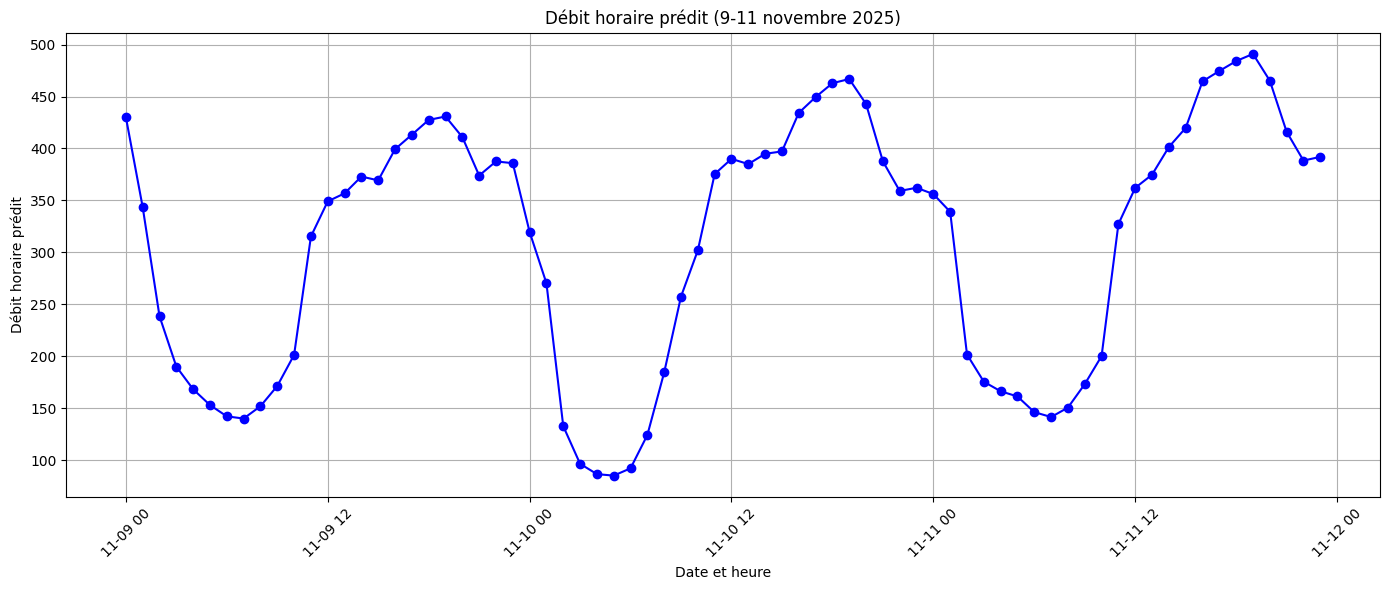

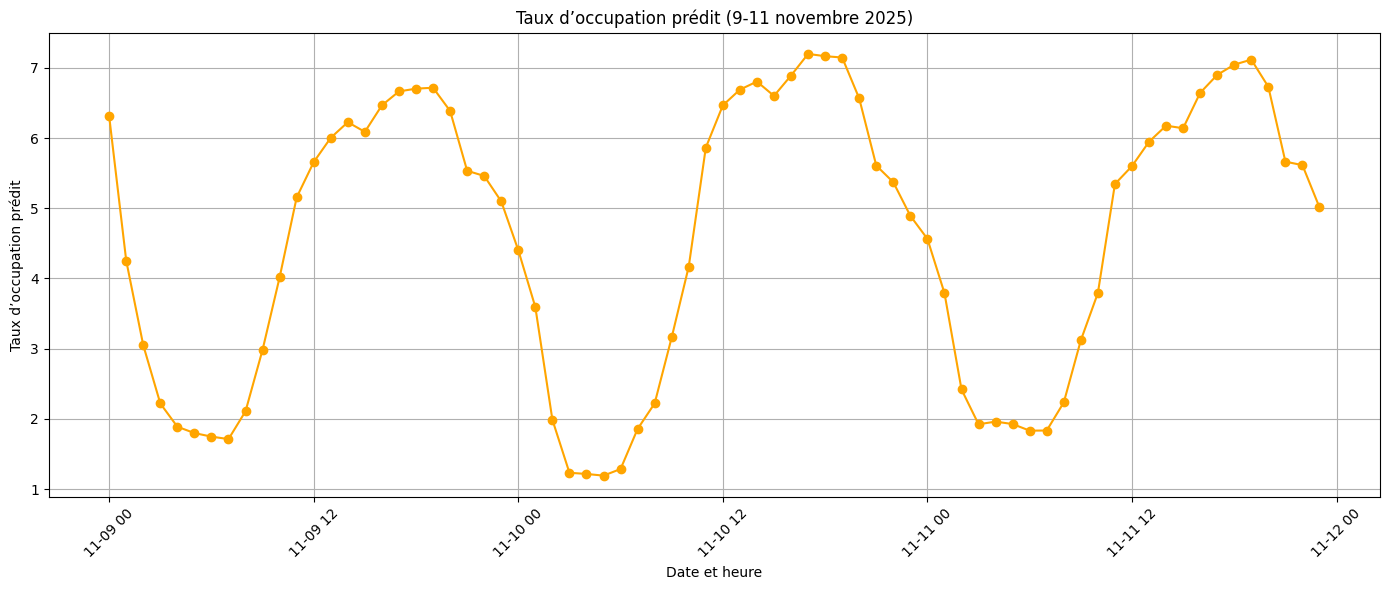

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Création du DataFrame date/heure 9-11 novembre 2025 ---
date_range = pd.date_range("2025-11-09 00:00:00", "2025-11-11 23:00:00", freq="H")
df_plot = pd.DataFrame({"date": date_range})

# --- Ajouter les prédictions y_pred ---
df_plot = pd.concat([df_plot.reset_index(drop=True), 
                     y_pred[['pred_Débit horaire', 'pred_Taux d\'occupation']].reset_index(drop=True)], axis=1)

# --- Graphique Débit horaire ---
plt.figure(figsize=(14,6))
plt.plot(df_plot['date'], df_plot['pred_Débit horaire'], color='blue', marker='o')
plt.xlabel('Date et heure')
plt.ylabel('Débit horaire prédit')
plt.title('Débit horaire prédit (9-11 novembre 2025)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Graphique Taux d’occupation ---
plt.figure(figsize=(14,6))
plt.plot(df_plot['date'], df_plot['pred_Taux d\'occupation'], color='orange', marker='o')
plt.xlabel('Date et heure')
plt.ylabel('Taux d’occupation prédit')
plt.title('Taux d’occupation prédit (9-11 novembre 2025)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [92]:
targets = ['Débit horaire', "Taux d'occupation"]

features_xgb = [
        'hour_sin', 'hour_cos', 
        'weekday_sin', 'weekday_cos', 
        'month_sin', 'month_cos', 
        'dayofyear_sin', 'dayofyear_cos',
        'is_weekend', 'is_holiday',
        'Vacances Scolaires Paris', 
        'temperature_2m (°C)', 'wind_speed_10m (km/h)',
        'precipitation (mm)', 'cloud_cover (%)',
        'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
        "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"]

df_xgb_convention = df_convention_xgb.copy()

lags_hours = [72, 168]  # 3 days and 1 week lags
df_xgb_convention, features_xgb_convention = create_lag_features(df_xgb_convention, targets=targets, lags_hours=lags_hours)

features_xgb_convention += features_xgb


xgb_model_convention = XGBoostModel(df_xgb_convention, features_xgb_convention, targets)
xgb_model_convention.full_train()

Full training completed on all data.


{'Débit horaire': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...),
 "Taux d'occupation": XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
      

In [93]:
X_test=df_test_convention_2025[features_xgb_convention]
y_pred=xgb_model_convention.predict_final(X_test)
print(y_pred)

    pred_Débit horaire  pred_Taux d'occupation
0           276.276611                1.810806
1           104.967247                0.609109
2            93.249229                0.522316
3            84.166344                0.447627
4            80.349998                0.433815
5            74.570793                0.427163
6            73.076469                0.428344
7            72.589531                0.593442
8            98.139305                0.940755
9           132.923523                1.128499
10          147.602432                1.260895
11          163.780426                1.537738
12          171.651443                1.546012
13          191.512833                1.546012
14          211.519485                1.546012
15          227.985428                2.362807
16          203.450821                2.506716
17          198.586105                2.583719
18          197.959778                2.444706
19          200.474777                2.389840
20          1

In [96]:
# --- Lire le CSV existant (Saint-Pères déjà présent) ---
df_output = pd.read_csv("output_bison_fûté.csv")

# --- Créer le DataFrame pour Convention ---
y_pred_convention_df = pd.DataFrame(y_pred)  # tes prédictions pour Convention

date_range_convention = pd.date_range("2025-11-09 00:00:00", "2025-11-11 23:00:00", freq="H")

df_convention = pd.DataFrame({
    'arc': 'Convention',
    'datetime': date_range_convention,
    'debit_horaire': y_pred_convention_df['pred_Débit horaire'],
    'taux_occupation': y_pred_convention_df["pred_Taux d'occupation"]
})

# --- Formater la colonne datetime ---
df_convention['datetime'] = df_convention['datetime'].dt.strftime('%Y-%m-%d %H:%M')

# --- Concaténer les deux DataFrames (Saint-Pères + Convention) ---
df_output = pd.concat([df_output, df_convention], axis=0).reset_index(drop=True)

# --- Réexporter en CSV ---
df_output.to_csv("output_bison_fûté.csv", index=False)


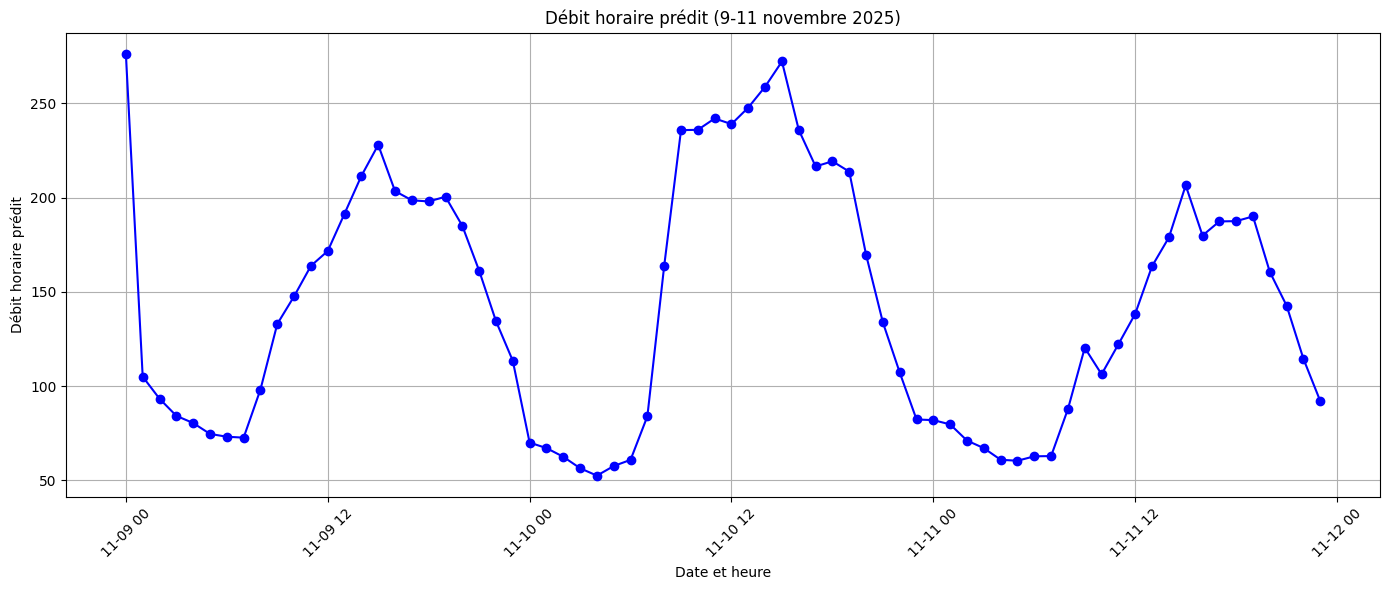

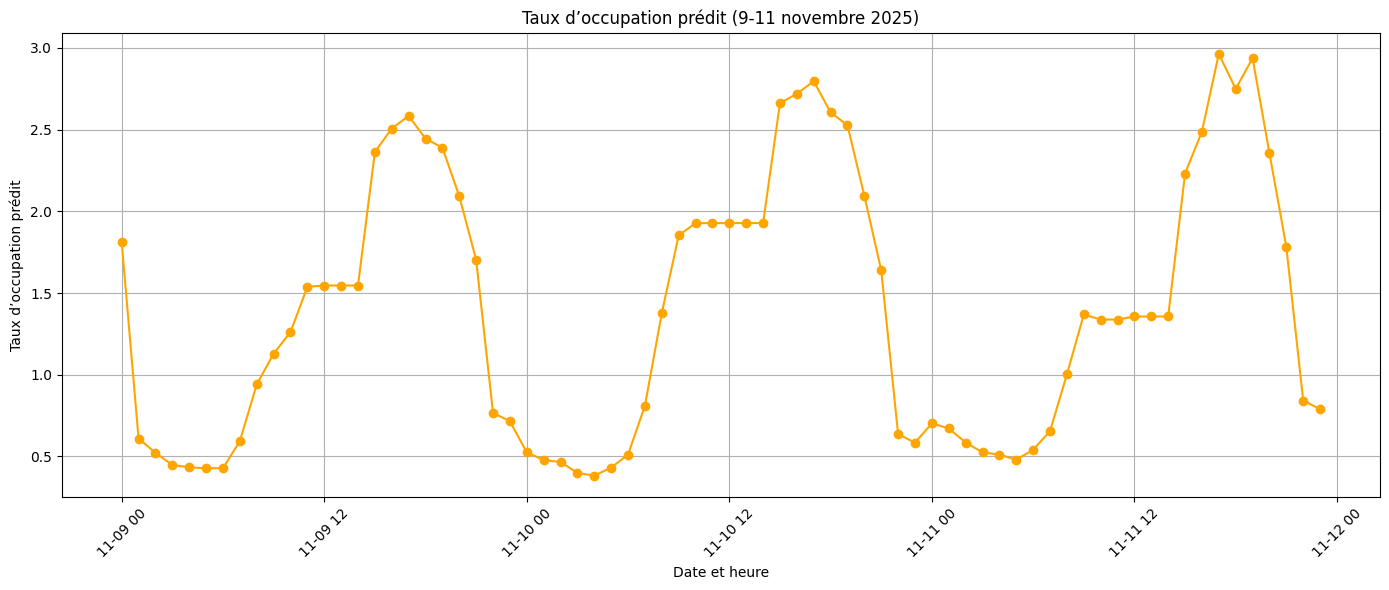

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Création du DataFrame date/heure 9-11 novembre 2025 ---
date_range = pd.date_range("2025-11-09 00:00:00", "2025-11-11 23:00:00", freq="H")
df_plot = pd.DataFrame({"date": date_range})

# --- Ajouter les prédictions y_pred ---
df_plot = pd.concat([df_plot.reset_index(drop=True), 
                     y_pred[['pred_Débit horaire', 'pred_Taux d\'occupation']].reset_index(drop=True)], axis=1)

# --- Graphique Débit horaire ---
plt.figure(figsize=(14,6))
plt.plot(df_plot['date'], df_plot['pred_Débit horaire'], color='blue', marker='o')
plt.xlabel('Date et heure')
plt.ylabel('Débit horaire prédit')
plt.title('Débit horaire prédit (9-11 novembre 2025)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Graphique Taux d’occupation ---
plt.figure(figsize=(14,6))
plt.plot(df_plot['date'], df_plot['pred_Taux d\'occupation'], color='orange', marker='o')
plt.xlabel('Date et heure')
plt.ylabel('Taux d’occupation prédit')
plt.title('Taux d’occupation prédit (9-11 novembre 2025)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [98]:
targets = ['Débit horaire', "Taux d'occupation"]

features_champs = [
        'hour_sin', 'hour_cos', 
        'weekday_sin', 'weekday_cos', 
        'month_sin', 'month_cos', 
        'dayofyear_sin', 'dayofyear_cos',
        'is_weekend', 'is_holiday',
        'Vacances Scolaires Paris', 
        'temperature_2m (°C)', 'wind_speed_10m (km/h)',
        'precipitation (mm)', 'cloud_cover (%)',
        'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
        "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"]

In [99]:
final_eval_size = 72
seq_length = 168

train_df_champs = df_champs_lstm.copy()

lstm_model_champs = LSTMTimeSeries(
    features=features_champs,
    targets=targets,
    seq_length=seq_length,
    pred_length=final_eval_size
)

lstm_model_champs.train_final(train_df_champs, epochs=1, batch_size=32)

291/291 ━━━━━━━━━━━━━━━━━━━━ 60s 199ms/step - loss: 0.5894 - mae: 0.5576 - mape: 204.9850


In [100]:
len(features_champs)

21

In [101]:
# Extraire les 168 dernières heures de train pour initier la séquence
last_train_seq_df = train_df_champs[features_champs].iloc[-168:].copy()

# Vérification
print(last_train_seq_df.shape)  # doit être (168, n_features)

# Appel de la prédiction
y_pred = lstm_model_champs.predict(last_train_seq_df)  # la méthode s'occupe du reshape
print(y_pred)  # devrait être (72, n_targets)


(168, 21)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
[[562.43463    11.057972 ]
 [516.903       8.610703 ]
 [416.79086     5.994475 ]
 [396.2519      6.019487 ]
 [372.39297     4.391663 ]
 [341.1964      2.4833179]
 [411.67426     6.5507007]
 [535.18024     6.676471 ]
 [602.83594     8.599423 ]
 [661.69434    11.379022 ]
 [747.6982     13.269283 ]
 [792.92444    17.187546 ]
 [770.35504    18.247087 ]
 [809.3678     20.048838 ]
 [793.3472     21.907452 ]
 [812.80774    22.149834 ]
 [780.2956     22.68435  ]
 [775.60205    20.920734 ]
 [801.7786     20.687603 ]
 [781.9983     20.396276 ]
 [784.62744    18.51051  ]
 [801.4829     16.775673 ]
 [777.2535     14.986217 ]
 [653.2257     12.365309 ]
 [619.02423    10.623807 ]
 [433.03598     8.774214 ]
 [422.27936     5.2685933]
 [286.61646     4.642201 ]
 [319.6226      4.956798 ]
 [298.06522     4.18539  ]
 [384.915       3.412869 ]
 [532.0222      6.6742835]
 [581.77655     9.37005  ]
 [714.1353     10.804362 ]
 [786.7602     13.9688635]
 [837.

In [102]:
df_output = pd.read_csv("output_bison_fûté.csv")


# --- Créer le DataFrame pour Champs-Élysées ---
date_range_champs = pd.date_range("2025-11-09 00:00:00", "2025-11-11 23:00:00", freq="H")

df_champs = pd.DataFrame({
    'arc': 'Champs-Elysées',
    'datetime': date_range_champs,
    'debit_horaire': y_pred[:,0],
    'taux_occupation': y_pred[:,1]
})

# --- Formater la colonne datetime ---
df_champs['datetime'] = df_champs['datetime'].dt.strftime('%Y-%m-%d %H:%M')

# --- Ajouter au CSV existant ---
df_output = pd.concat([df_output, df_champs], axis=0).reset_index(drop=True)

# --- Réexporter ---
df_output.to_csv("output_bison_fûté.csv", index=False)


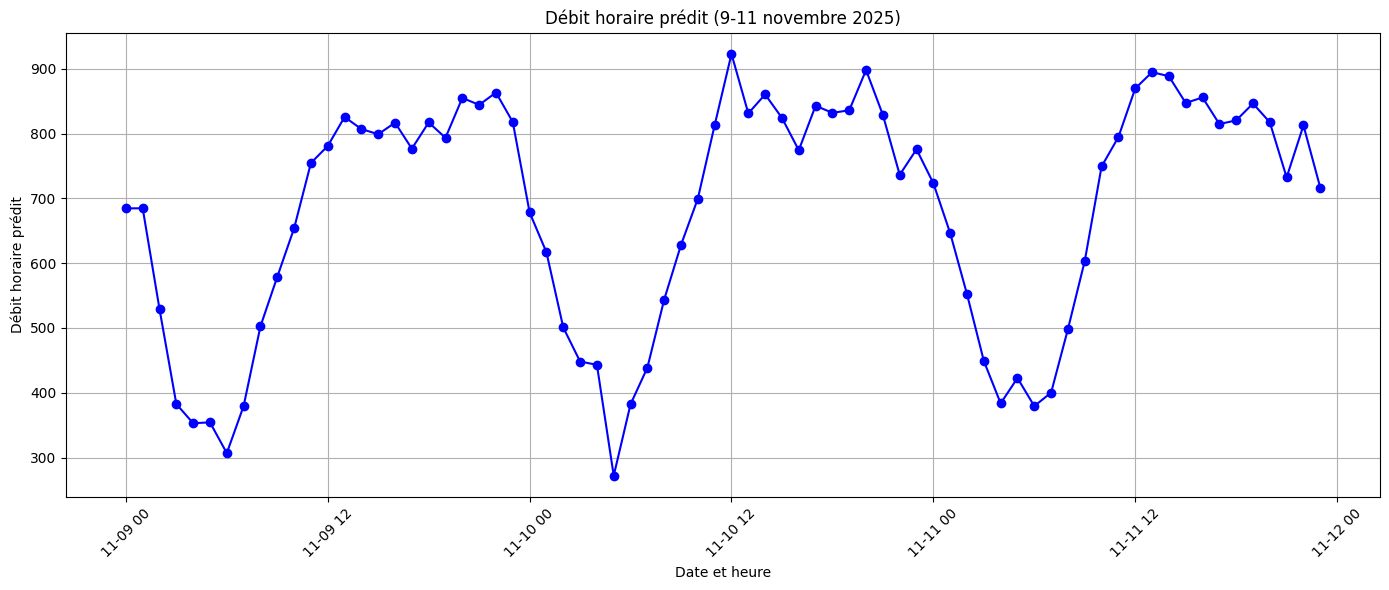

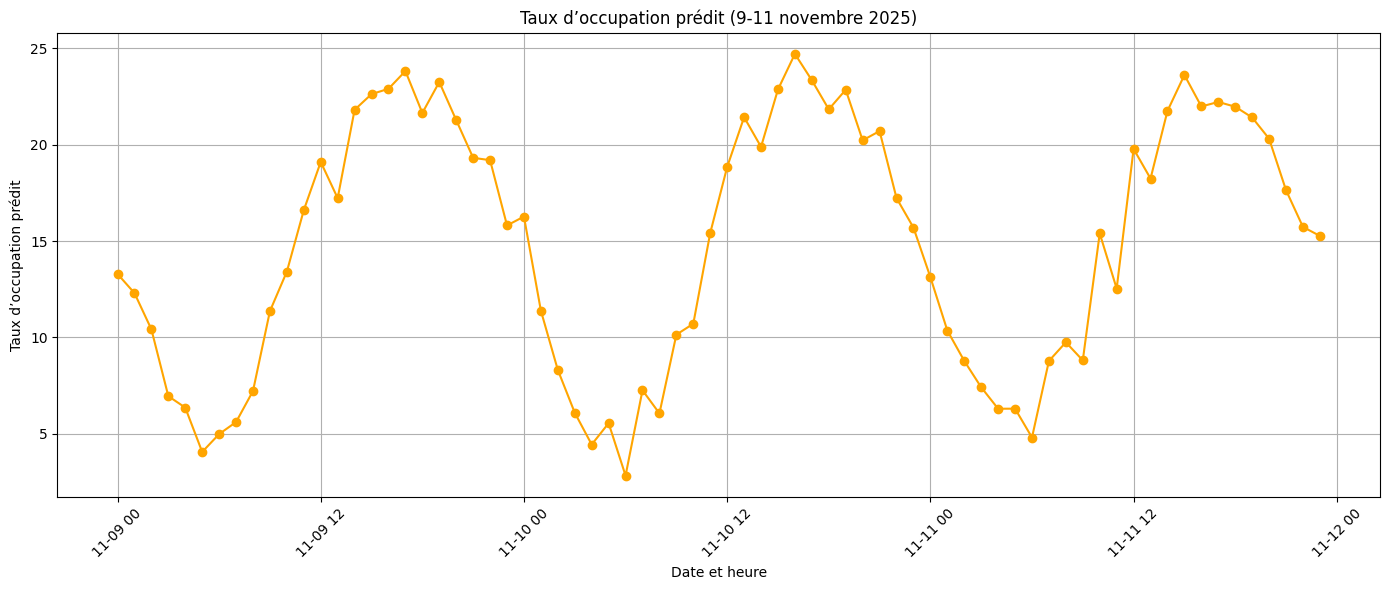

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Création du DataFrame date/heure 9-11 novembre 2025 ---
date_range = pd.date_range("2025-11-09 00:00:00", "2025-11-11 23:00:00", freq="H")
df_plot = pd.DataFrame({"date": date_range})

# --- Convertir y_pred en DataFrame et ajouter au df_plot ---
y_pred_df = pd.DataFrame(y_pred, columns=['pred_Débit horaire', 'pred_Taux d\'occupation'])
df_plot = pd.concat([df_plot.reset_index(drop=True), y_pred_df.reset_index(drop=True)], axis=1)

# --- Graphique Débit horaire ---
plt.figure(figsize=(14,6))
plt.plot(df_plot['date'], df_plot['pred_Débit horaire'], color='blue', marker='o')
plt.xlabel('Date et heure')
plt.ylabel('Débit horaire prédit')
plt.title('Débit horaire prédit (9-11 novembre 2025)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Graphique Taux d’occupation ---
plt.figure(figsize=(14,6))
plt.plot(df_plot['date'], df_plot['pred_Taux d\'occupation'], color='orange', marker='o')
plt.xlabel('Date et heure')
plt.ylabel('Taux d’occupation prédit')
plt.title('Taux d’occupation prédit (9-11 novembre 2025)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Verify CSV

In [106]:
from datetime import datetime
from pathlib import Path

def test_format_and_export_output(output_df, output_directory, name_of_the_group):
    output_columns = {
        "arc": object,
        "datetime": object,
        "debit_horaire": float,
        "taux_occupation": float
    }

    # 1. Check relevant columns are in output dataframe
    assert sorted(list(output_df.columns)) == list(output_columns.keys()), \
        "Some columns are missing or unnecessary columns are in output"

    # 2. Check types
    for col, col_type in output_columns.items():
        assert output_df[col].dtype == col_type, f"Column {col} does not have type {col_type}"

    # 3. Check datetime string has right format
    try:
        output_df.datetime.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M"))
    except ValueError as e:
        raise e

    # 4. Check `arc` columns has right values
    expected_arcs = ["Champs-Elysées", "Convention", "Saint-Pères"]
    assert sorted(list(output_df["arc"].unique())) == expected_arcs, \
        "Output does not have expected unique values for column `arc`"

    # 5. Check dataframe has right number of rows
    assert output_df.shape[0] == 216, f"Expected number of rows is 360, output has {output_df.shape[0]}"

    # 6. Export output
    output_path = Path(output_directory) / f"output_{name_of_the_group}.csv"
    print(f"[SAVE OUTPUT] Saving output here: {output_path}")
    output_df[list(output_columns.keys())].to_csv(output_path, sep=";")



my_output=pd.read_csv("output_bison_fûté.csv")

test_format_and_export_output(
    output_df=my_output,
    output_directory=".",  # le dossier courant
    name_of_the_group="bison_fûté"
)


[SAVE OUTPUT] Saving output here: output_bison_fûté.csv
